# Installations

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install bitsandbytes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.1 MB/s eta 0:00:00


# Imports

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from captum.attr import (
    IntegratedGradients,
    InputXGradient,
    FeatureAblation,
    ShapleyValues,
    FeaturePermutation,
    LLMAttribution,
    LLMGradientAttribution,
    LayerIntegratedGradients,
    TextTokenInput,
    ShapleyValueSampling,
    LRP,
)
from captum.attr import visualization as viz
import random
import pandas as pd
import bitsandbytes as bnb
import numpy as np

seed = 26
torch.manual_seed(seed)

# Load dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/sst2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
train_dataset = dataset['train']

for i in range(50):
  print(f"{train_dataset[i]['idx']} (label={train_dataset[i]['label']}): {train_dataset[i]['sentence']}")

0 (label=0): hide new secretions from the parental units 
1 (label=0): contains no wit , only labored gags 
2 (label=1): that loves its characters and communicates something rather beautiful about human nature 
3 (label=0): remains utterly satisfied to remain the same throughout 
4 (label=0): on the worst revenge-of-the-nerds clichés the filmmakers could dredge up 
5 (label=0): that 's far too tragic to merit such superficial treatment 
6 (label=1): demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . 
7 (label=1): of saucy 
8 (label=0): a depressed fifteen-year-old 's suicidal poetry 
9 (label=1): are more deeply thought through than in most ` right-thinking ' films 
10 (label=0): goes to absurd lengths 
11 (label=0): for those moviegoers who complain that ` they do n't make movies like they used to anymore 
12 (label=0): the part where nothing 's happening , 
13 (label=0): saw how bad this

In [ ]:
idx = [8, 9, 14, 20, 26]

In [ ]:
sentences = []
labels = []

for i in idx:
  sentences.append(train_dataset[i]['sentence'])
  labels.append('positive' if train_dataset[i]['label'] == 1 else 'negative')

In [ ]:
sentences

["a depressed fifteen-year-old 's suicidal poetry ",
 "are more deeply thought through than in most ` right-thinking ' films ",
 'lend some dignity to a dumb story ',
 'equals the original and in some ways even betters it ',
 "which half of dragonfly is worse : the part where nothing 's happening , or the part where something 's happening "]

# Load model

In [ ]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = "10000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
        token="TOKEN",
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, token="TOKEN")

    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

In [ ]:
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

# Prompt

In [ ]:
device = "cuda"

In [ ]:
def get_prompt(sentence):
  return f"Classify the following sentence as either positive or negative: {sentence}. \
    Reply only 'positive' or 'negative'. The sentence is "

def prepare_input(sentence):
  messages = [
      {"role": "user", "content": get_prompt(sentence)}
  ]

  return tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)

## Example, visualization

In [ ]:
sentence = "the greatest musicians"
model_inputs = prepare_input(sentence)

generated_ids = model.generate(model_inputs, max_new_tokens=2, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(decoded[0])

_, answer = decoded[0].split("[/INST]")
answer

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Classify the following sentence as either positive or negative: the greatest musicians.     Reply only 'positive' or 'negative'. The sentence is  [/INST] positive.


' positive.'

In [ ]:
sentence = "the greatest musicians"
target = "positive"

inp = TextTokenInput(
        get_prompt(sentence),
        tokenizer,
        skip_tokens=[1],  # skip the special token for the start of the text <s>
)

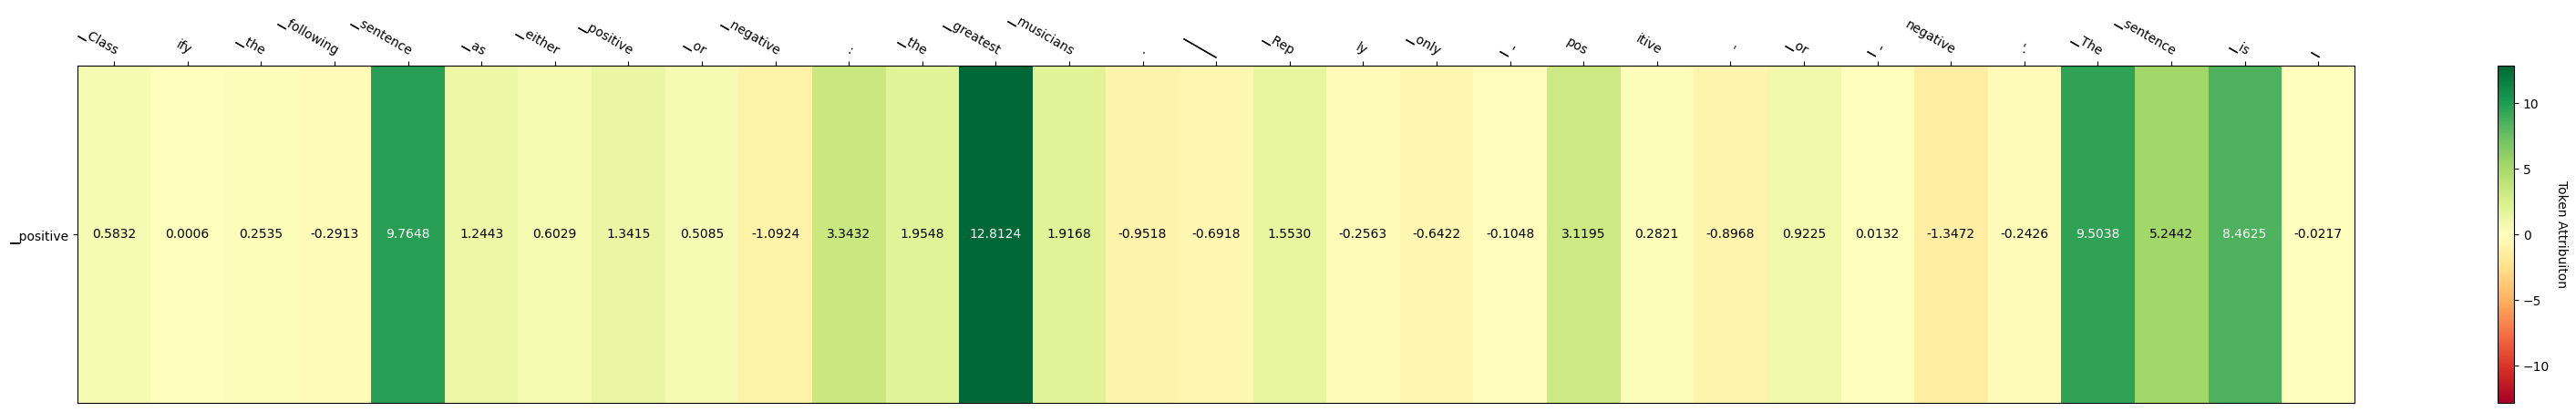

In [ ]:
fa_llm_attr = LLMAttribution(FeatureAblation(model), tokenizer)

fa_llm_attr_res = fa_llm_attr.attribute(inp, target=target)

fa_llm_attr_res.plot_token_attr(show=True)

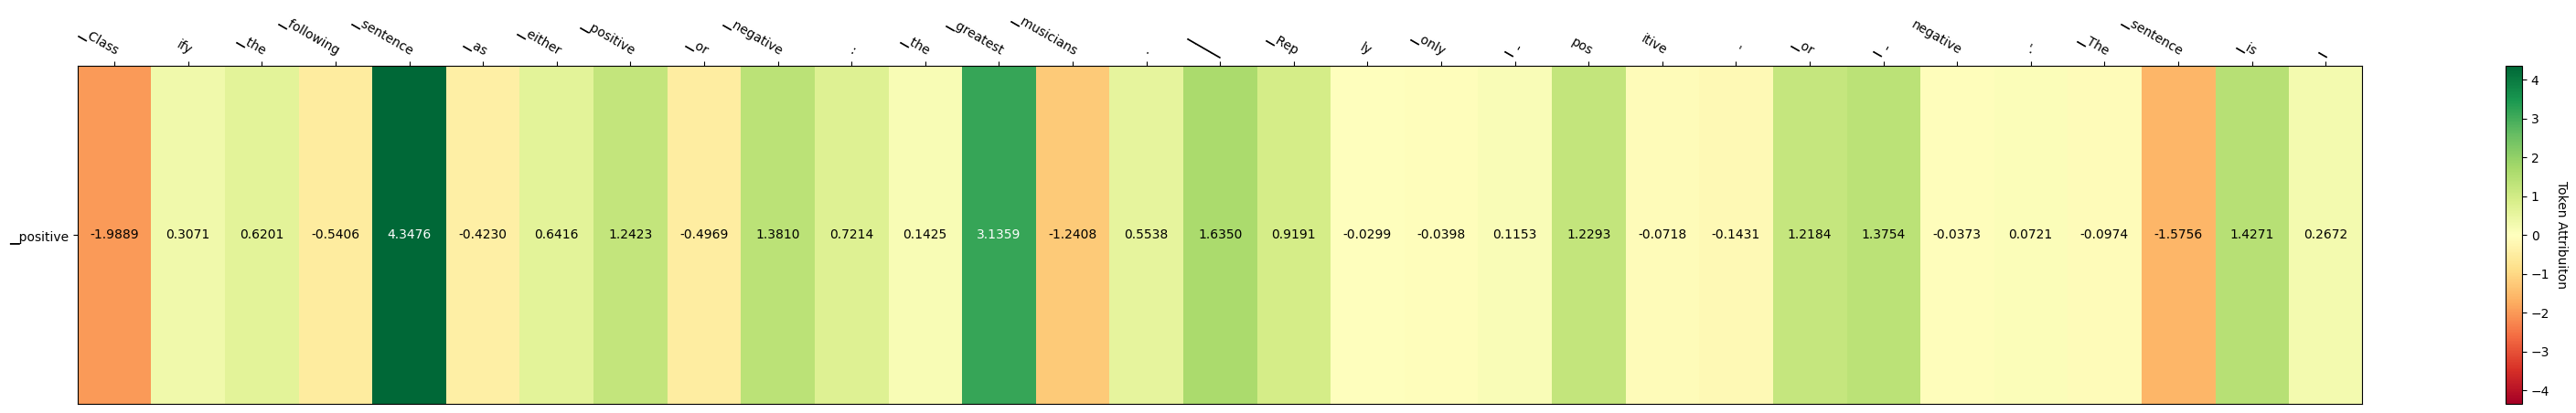

In [ ]:
sv = ShapleyValueSampling(model)

sv_llm_attr = LLMAttribution(sv, tokenizer)

attr_res = sv_llm_attr.attribute(inp, target=target, n_samples=5)

attr_res.plot_token_attr(show=True)

In [ ]:
sentence = "saw how bad this movie was"
model_inputs = prepare_input(sentence)

generated_ids = model.generate(model_inputs, max_new_tokens=2, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(decoded[0])

_, answer = decoded[0].split("[/INST]")
answer

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Classify the following sentence as either positive or negative: saw how bad this movie was.     Reply only 'positive' or 'negative'. The sentence is  [/INST] negative.


' negative.'

In [ ]:
target = "negative"

inp = TextTokenInput(
        get_prompt(sentence),
        tokenizer,
        skip_tokens=[1],  # skip the special token for the start of the text <s>
)

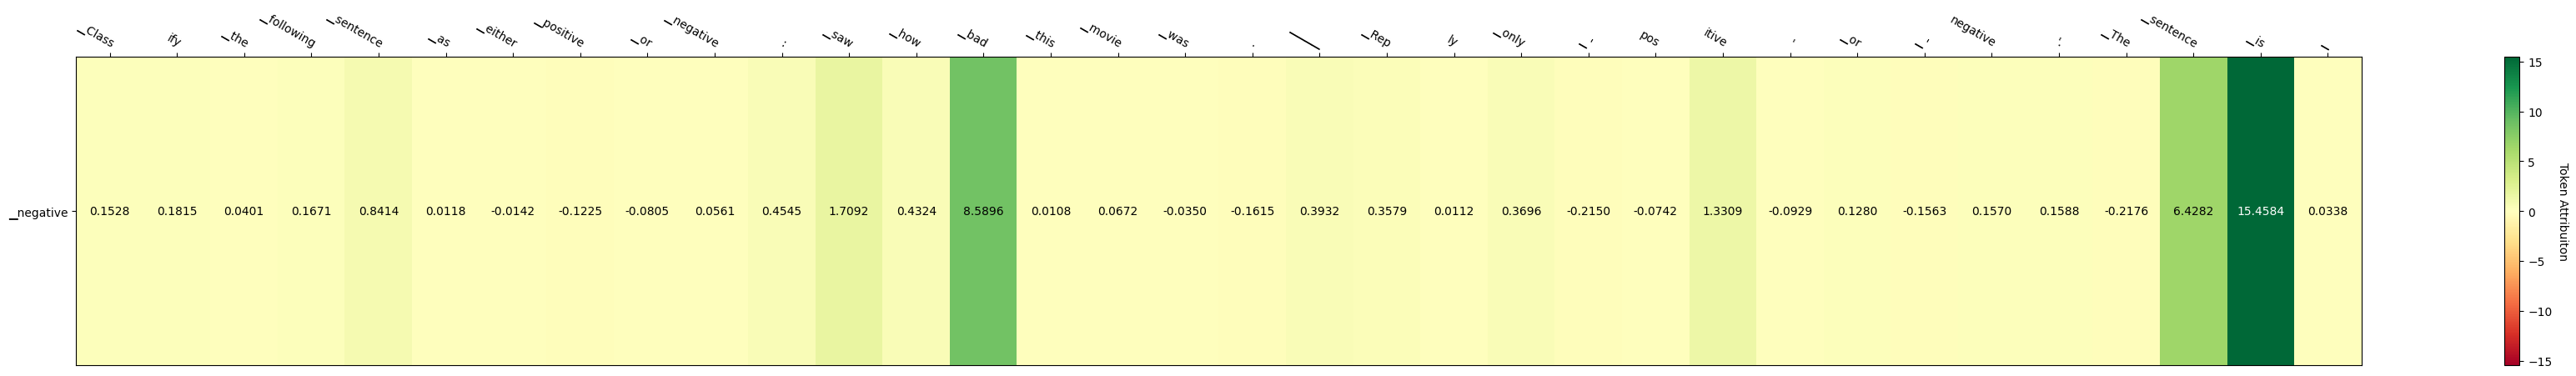

In [ ]:
fa_llm_attr = LLMAttribution(FeatureAblation(model), tokenizer)

fa_llm_attr_res = fa_llm_attr.attribute(inp, target=target)

fa_llm_attr_res.plot_token_attr(show=True)

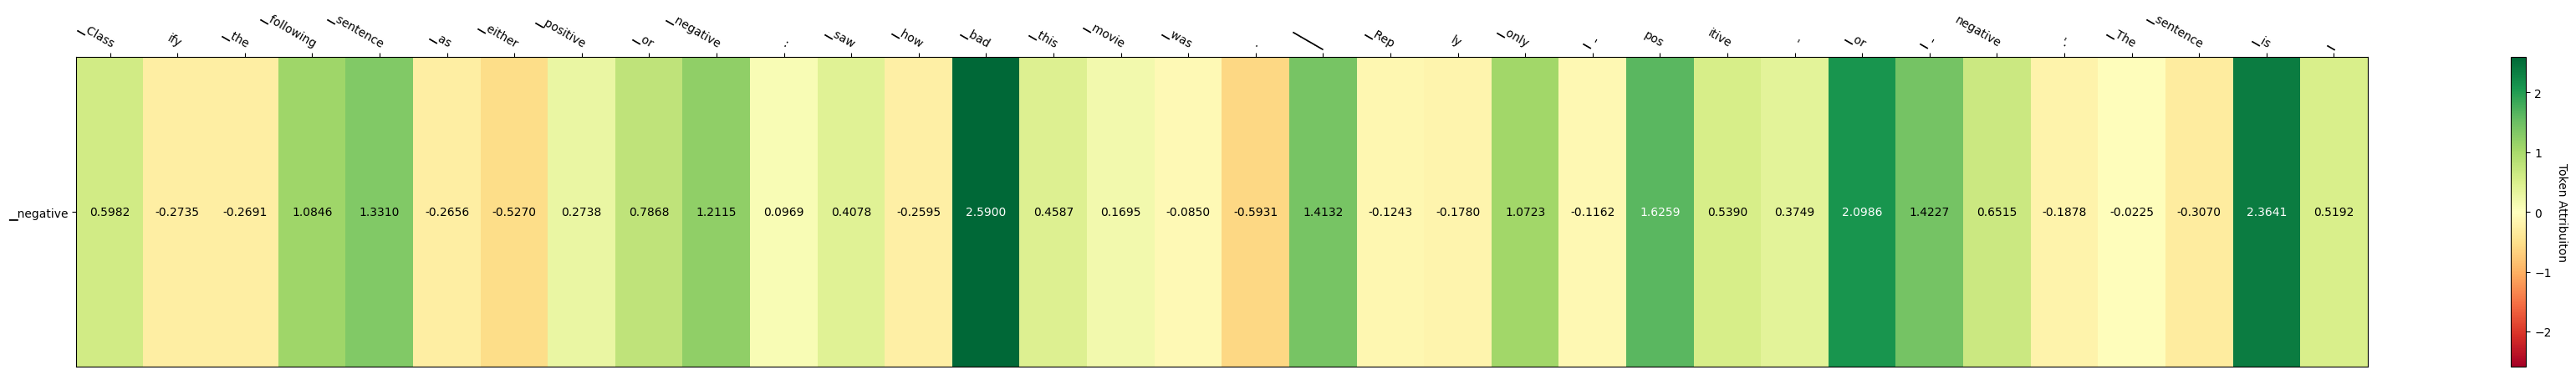

In [ ]:
sv = ShapleyValueSampling(model)

sv_llm_attr = LLMAttribution(sv, tokenizer)

attr_res = sv_llm_attr.attribute(inp, target=target, n_samples=5)

attr_res.plot_token_attr(show=True)

# Comparison

In [ ]:
import time
from tqdm import tqdm

In [ ]:
def predict_sentiment(sentence):
  model_inputs = prepare_input(sentence)

  generated_ids = model.generate(model_inputs, max_new_tokens=2, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
  _, answer = decoded[0].split("[/INST]")

  if 'positive' in answer.lower():
    return 'positive'

  if 'negative' in answer.lower():
    return 'negative'

  return answer

In [ ]:
abl_attr = LLMAttribution(FeatureAblation(model), tokenizer)
shap_attr = LLMAttribution(ShapleyValueSampling(model), tokenizer)

prefix_len = 11
suffix_len = 17

threshold = 1

abl_time = np.zeros(len(sentences))
shap_time = np.zeros(len(sentences))

abl_suff = 0
shap_suff = 0

abl_attr_results = []
shap_attr_results = []

abl_selected_attr_results = []
shap_selected_attr_results = []

preds = []

for i, (lbl, sentence) in tqdm(enumerate(zip(labels, sentences))):
    target = predict_sentiment(sentence)

    inp = TextTokenInput(
        get_prompt(sentence),
        tokenizer,
        skip_tokens=[1],  # skip the special token for the start of the text <s>
    )

    start_time = time.time()
    abl_attr_res = abl_attr.attribute(inp, target=target)
    abl_time[i] = time.time() - start_time
    abl_attr_results.append(abl_attr_res)

    start_time = time.time()
    shap_attr_res = shap_attr.attribute(inp, target=target, n_samples=5)
    shap_time[i] = time.time() - start_time
    shap_attr_results.append(shap_attr_res)


    # Select tokens with attribution scores greater than the threshold
    abl_selected_tokens = [token for token, score in zip(abl_attr_res.input_tokens[prefix_len + 1 : -suffix_len],
                                                         abl_attr_res.token_attr[0][prefix_len + 1 : -suffix_len]) if score > threshold]
    new_abl_sentence = tokenizer.convert_tokens_to_string(abl_selected_tokens)

    shap_selected_tokens = [token for token, score in zip(shap_attr_res.input_tokens[prefix_len + 1 : -suffix_len],
                                                          shap_attr_res.token_attr[0][prefix_len + 1 : -suffix_len]) if score > threshold]
    new_shap_sentence = tokenizer.convert_tokens_to_string(shap_selected_tokens)

    #Counting faithfulness: sufficiency
    abl_pred = predict_sentiment(new_abl_sentence)
    if abl_pred == target:
      abl_suff += 1

    shap_pred = predict_sentiment(new_shap_sentence)
    if shap_pred == target:
      shap_suff += 1

    preds.append((target, abl_pred, shap_pred))

0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
1it [03:13, 193.27s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id

In [ ]:
from tabulate import tabulate

table_data = [
    ["FeatureAblation", abl_time.mean(), abl_suff / len(sentences)],
    ["ShapleyValueSampling", shap_time.mean(), shap_suff / len(sentences)]
]
headers = ["Method", "Average Time (s)", "Sufficiency"]

print(tabulate(table_data, headers=headers, tablefmt="pretty"))

+----------------------+-------------------+-------------+
|        Method        | Average Time (s)  | Sufficiency |
+----------------------+-------------------+-------------+
|   FeatureAblation    | 71.64167747497558 |     0.2     |
| ShapleyValueSampling | 354.4597337245941 |     0.0     |
+----------------------+-------------------+-------------+


In [ ]:
labels

['negative', 'positive', 'negative', 'positive', 'negative']

In [ ]:
preds

[('negative', 'negative', ' Neut'),
 (' This sentence', " I'", " I'"),
 (' neutral.', 'negative', ' The sentence'),
 ('positive', " I'", ' Neut'),
 (' The sentence', " I'", ' I cannot')]

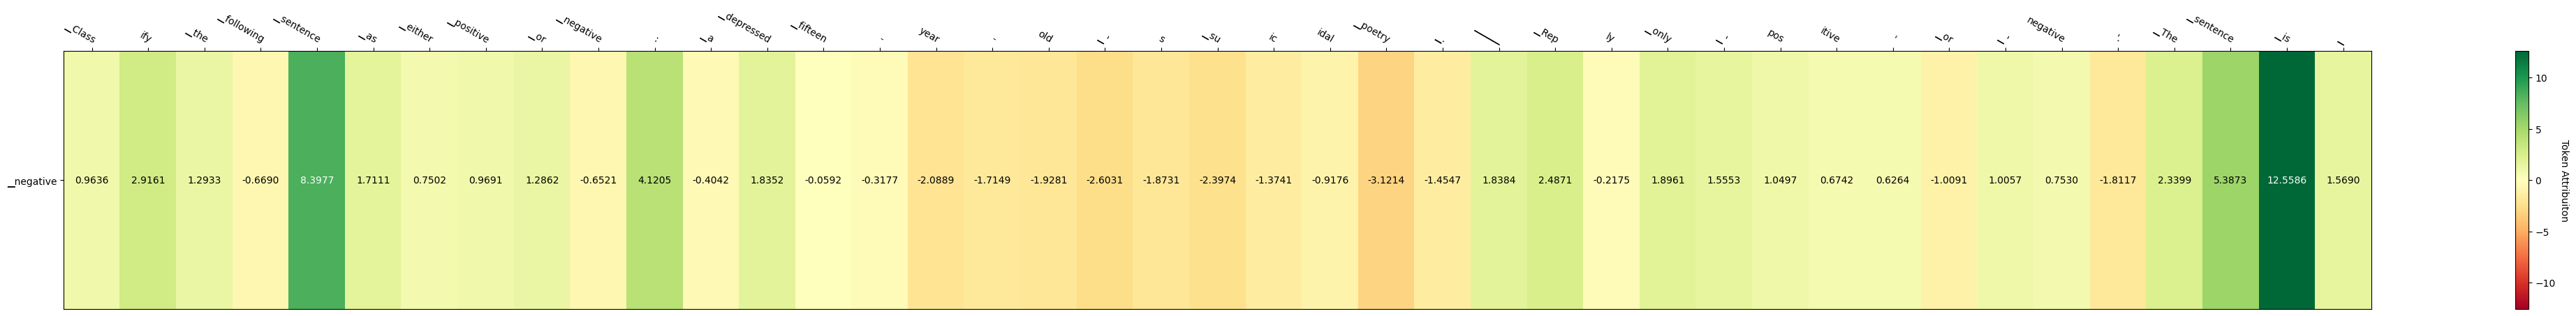

In [ ]:
abl_attr_results[0].plot_token_attr(show=True)

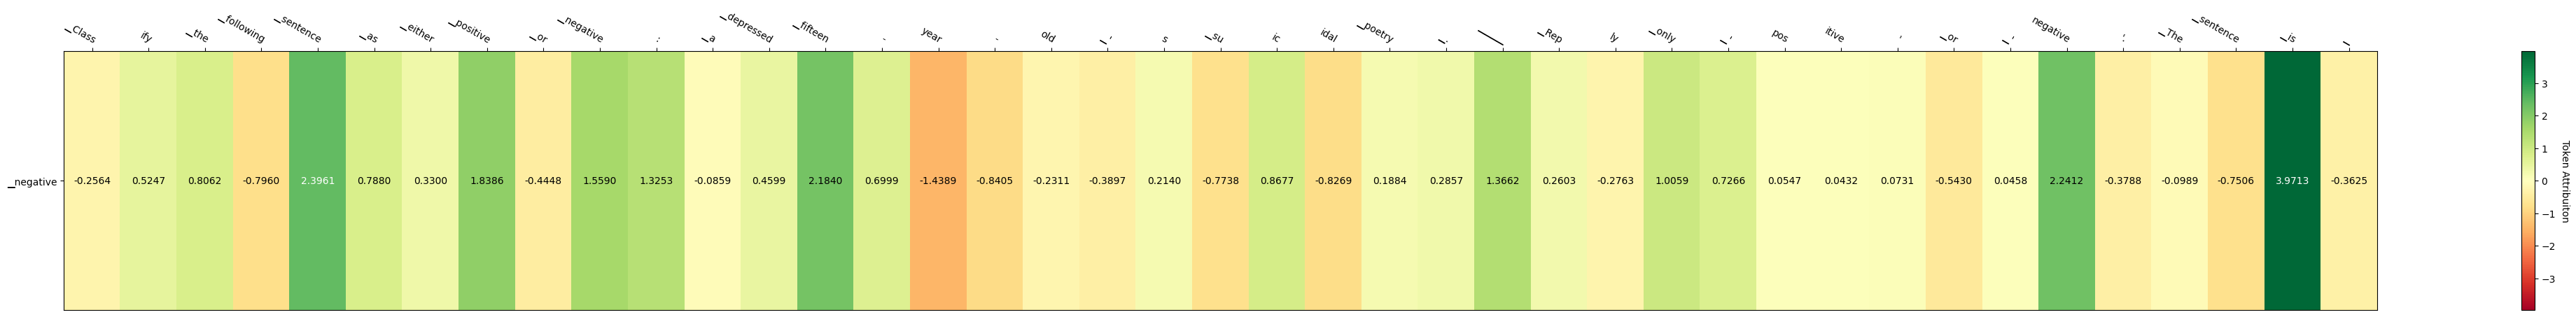

In [ ]:
shap_attr_results[0].plot_token_attr(show=True)

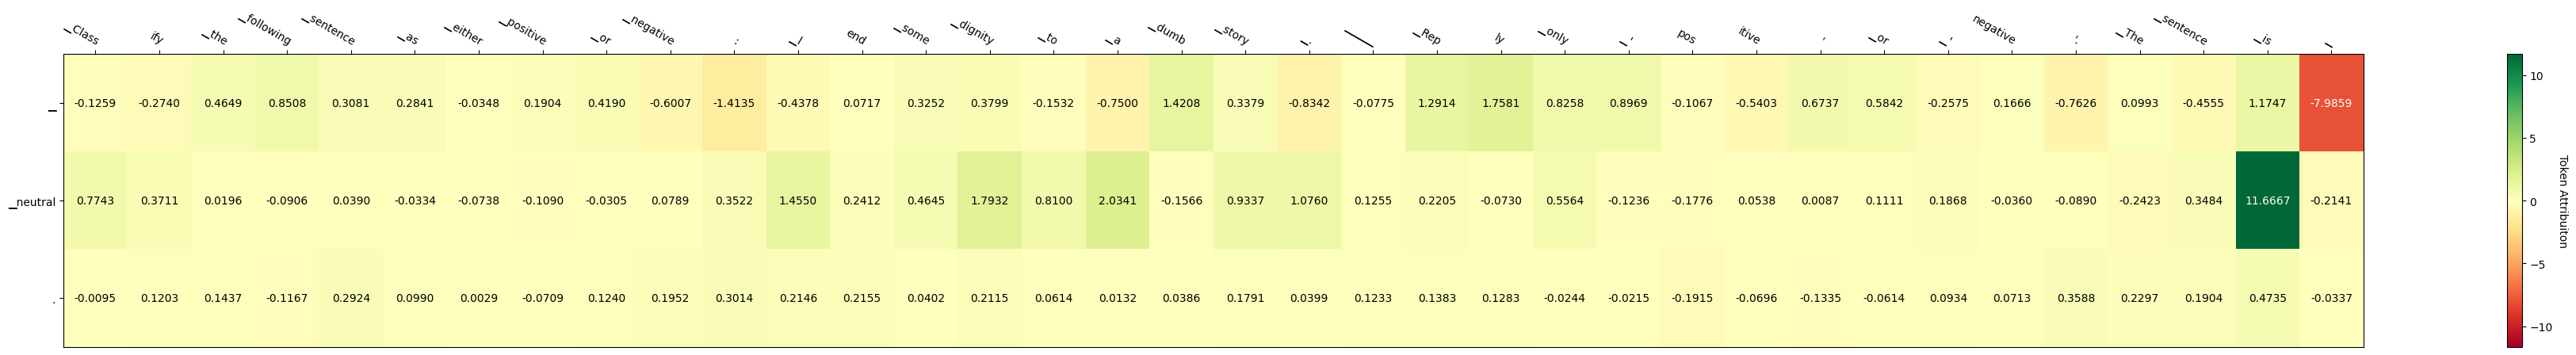

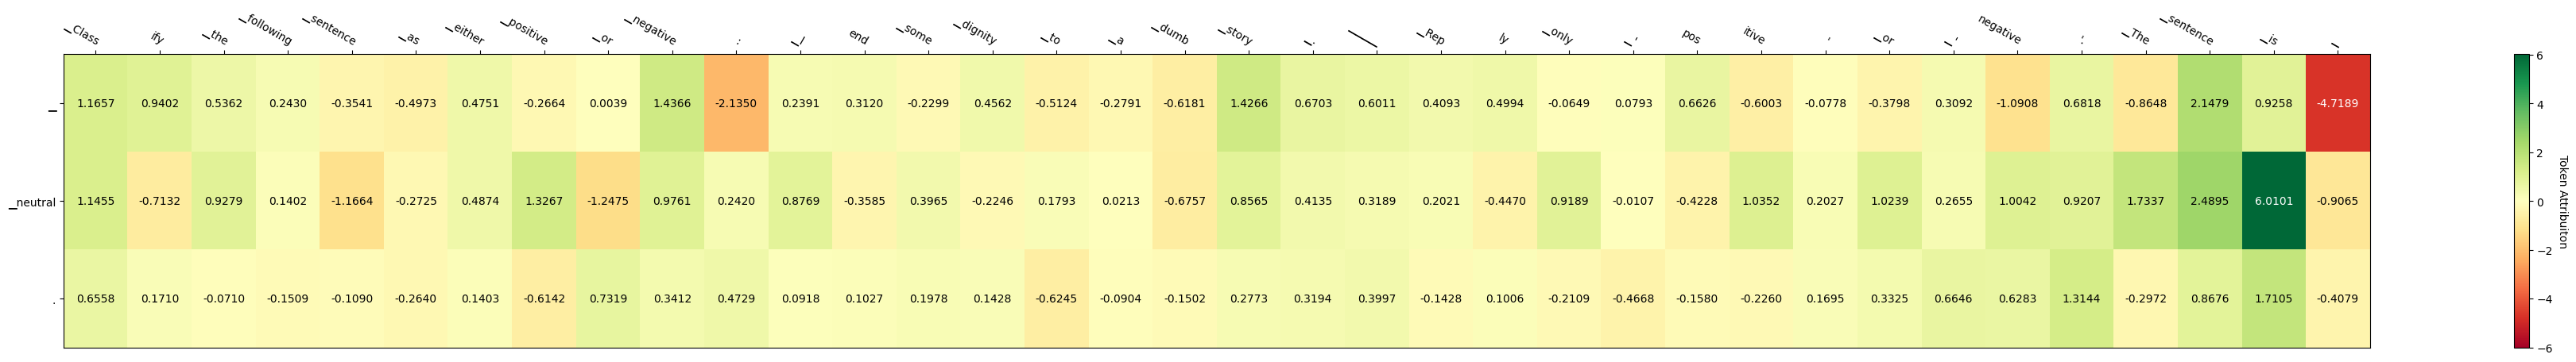

In [ ]:
abl_attr_results[2].plot_token_attr(show=True)
shap_attr_results[2].plot_token_attr(show=True)

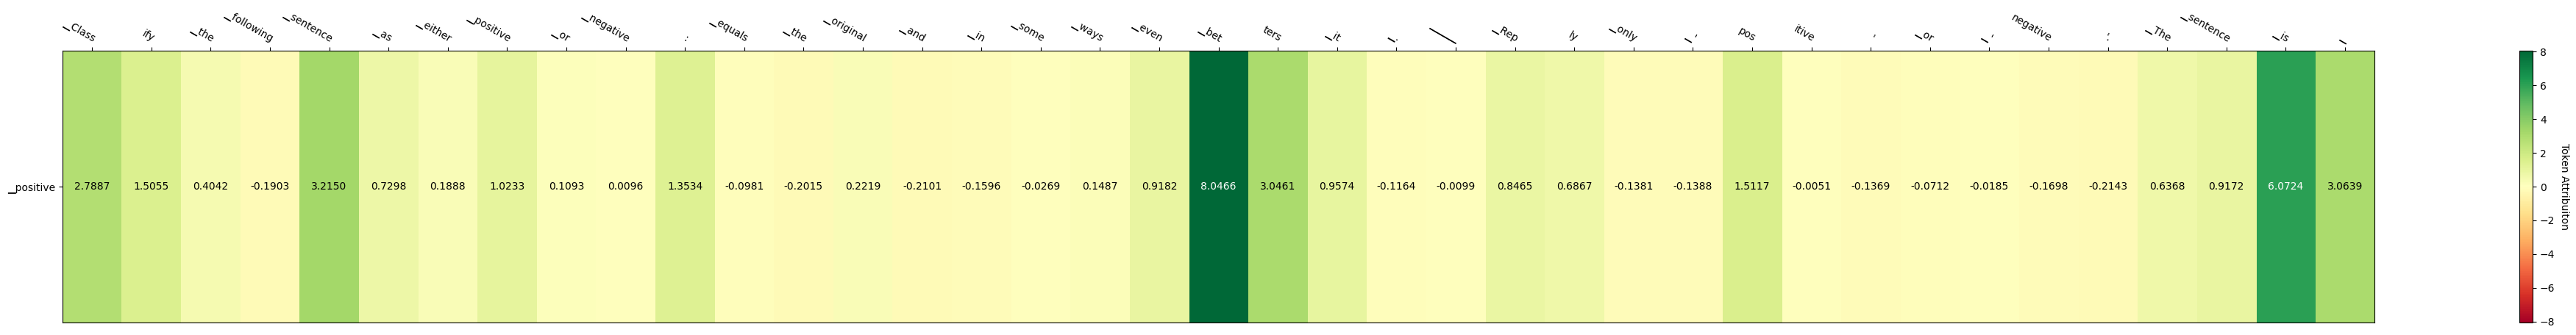

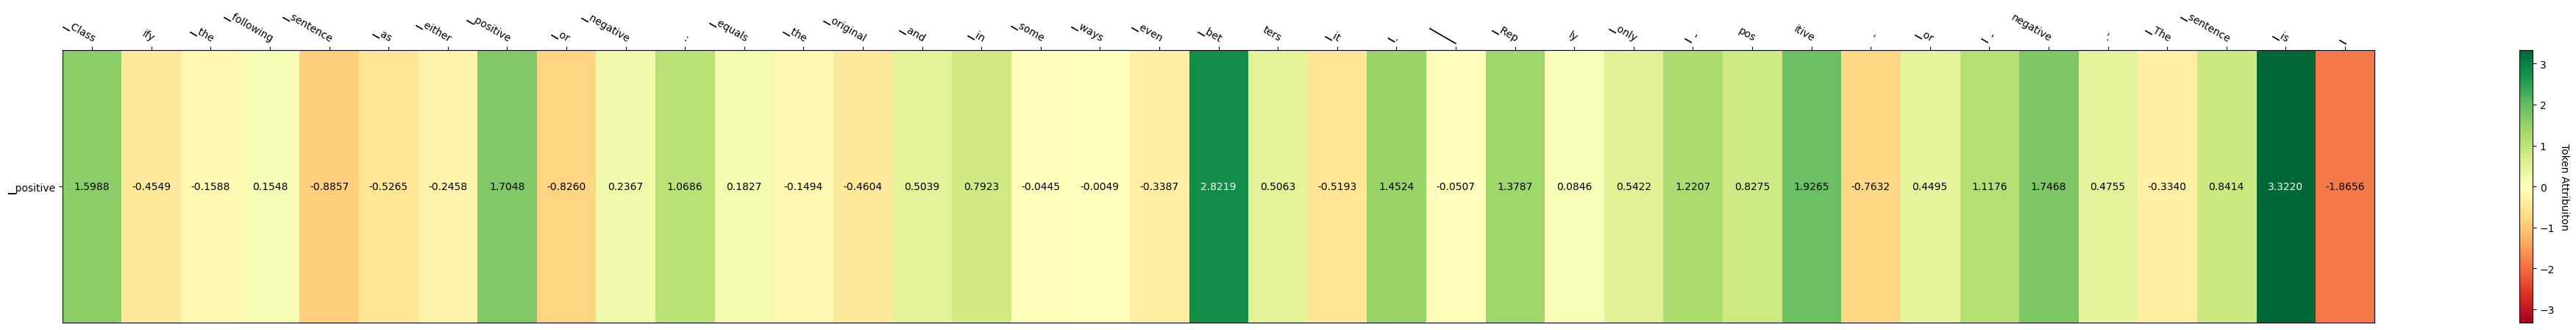

In [ ]:
abl_attr_results[3].plot_token_attr(show=True)
shap_attr_results[3].plot_token_attr(show=True)

## Gradient Methods require much memory.

In [ ]:
ig = LayerIntegratedGradients(model, model.model.embed_tokens)
llm_attr = LLMGradientAttribution(ig, tokenizer)

inp = TextTokenInput(
        get_prompt(sentence),
        tokenizer,
)
grad_attr = llm_attr.attribute(inp)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 

# Dev: finding prompt

In [ ]:
def prepare_input(sentence):
  def prompt(sent):
    return f"Classify the following sentence as either positive or negative: {sent}. \
    Write only one word: 'positive' or 'negative'."

  example_sentence = "“that loves its characters and communicates something rather beautiful about human nature.”"

  messages = [
      {"role": "user", "content": prompt(example_sentence)},
      {"role": "assistant", "content": "positive"},
      {"role": "user", "content": prompt(sentence)}
  ]

  return tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)


sentence = "the greatest musicians"
model_inputs = prepare_input(sentence)

generated_ids = model.generate(model_inputs, max_new_tokens=100, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> [INST] Classify the following sentence as either positive or negative: “that loves its characters and communicates something rather beautiful about human nature.”.     Write only one word: 'positive' or 'negative'. [/INST]positive</s> [INST] Classify the following sentence as either positive or negative: the greatest musicians.     Write only one word: 'positive' or 'negative'. [/INST]positive. The sentence implies praise for the musicians being referred to as 'the greatest'.</s>
